# Part 3. Extracting signal from a region of interest

In Part 1, we preprocessed the data (or, at least, explored *how* you could go about preprocessing your data). Let's just use the `fmriprep`-preprocessed data for the remainder of the tutorial. Here, we will extract signal from a region of interest: striatum. Striatum is part of the Basal Ganglia, and has repeatedly been implicated in response caution adjustments (e.g., [Forstmann et al 2008](http://www.pnas.org/content/105/45/17538/#F2); [Van Maanen et al 2011](http://www.jneurosci.org/content/31/48/17488)). In Part 3 and 4 of this tutorial, we'll see if we can replicate this result.

In order to extract signal from a region of interest, we need a mask that tells us where this ROI lies in the brain. Since `fmriprep` registered ('normalized') our data to MNI152-space, we can use a mask from an atlas in MNI152-space.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from nipype.interfaces import fsl
import nilearn.datasets

%matplotlib inline

## A look at masks

In the directory `/data/masks/` you can find various masks, including one for the left and one for the right striatum

In [2]:
!ls /data/masks

ATAG	      GPe_R.nii.gz  GPi_R.nii.gz  STR_R.nii.gz
GPe_L.nii.gz  GPi_L.nii.gz  STR_L.nii.gz


Let's load a mask and see what it looks like.

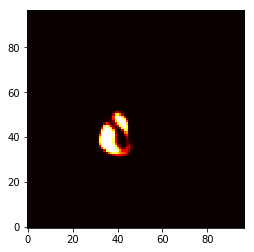

In [3]:
str_l = nib.load('/data/masks/STR_L.nii.gz').get_data()
plt.imshow(str_l[:, 68, :].T, origin='lower', cmap=plt.cm.hot)

Note that this is a *probabilistic* map. The colors in the above plot indicate the *probability* for each voxel that is is part of any given individual's left striatum. Further, probabilities of 0 lead to a black pixel in the plot above.

Let's mask all voxels that have a probability of 50% or less of belonging to any of the striatal parts. This way, they won't end up as black pixels when we plot them, but become transparant

In [4]:
str_l = np.ma.masked_less(str_l, 0.5)

Now, `str_l` is a 3D-matrix indicating for each voxel the probability that it belongs to the left striatum. What does this look like?

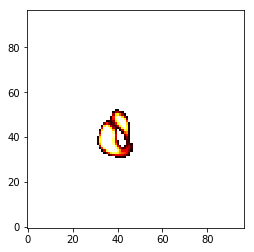

In [5]:
plt.imshow(str_l[:, 68, :].T, origin='lower', cmap=plt.cm.hot)

The background is now white instead of black, which doesn't help much. But now we can superimpose this mask on an MNI152 template

In [6]:
# Load the MNI template
mni = nib.load('/data/mni_icbm152_nlin_asym_09c/2mm_T1.nii.gz').get_data()

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


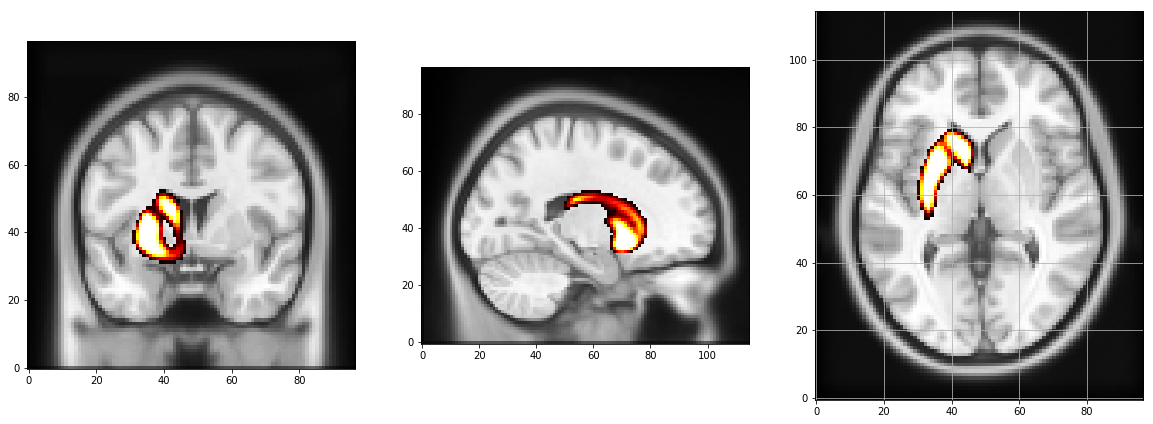

In [9]:
plt.figure(figsize=(20, 10))

plt.subplot(131)
plt.imshow(mni[:, 68, :].T,origin='lower', cmap=plt.cm.gray)
plt.imshow(str_l[:, 68, :].T,origin='lower', cmap=plt.cm.hot)
plt.grid('off')

plt.subplot(132)
plt.imshow(mni[38, :, :].T,origin='lower', cmap=plt.cm.gray)
plt.imshow(str_l[38, :, :].T,origin='lower', cmap=plt.cm.hot)
plt.grid('off')

plt.subplot(133)
plt.imshow(mni[:, :, 40].T,origin='lower', cmap=plt.cm.gray)
plt.imshow(str_l[:, :, 40].T,origin='lower', cmap=plt.cm.hot)
plt.grid('off')

And that's where left striatum is located probabilistically

Note that the `str_l` variable is a kind of image. You can apply image processing tools to it; for example, to find the center of mass (this is how the slices plotting above were chosen)

In [8]:
import scipy as sp
from scipy import ndimage
com = ndimage.center_of_mass(str_l)
com

(38.033724345230205, 68.37897524999154, 40.79747029165641)

1) Can you make the same plots for right striatum? Find the center of mass, and plot it on an MNI152-brain

## Extracting signal from a masked region
Back to Nipype. Nipype contains interfaces that allows you to extract a time series *meaned* over a region of interest. The interface is called `ImageMeants()`. Let's first see how this works

In [10]:
# We'll need these libraries below
from nipype.interfaces import fsl
import nipype.pipeline.engine as pe
import nipype.interfaces.io as nio

In [11]:
extracter = fsl.ImageMeants()
extracter.inputs.in_file = '/data/deriv/fmriprep/sub-483/func/sub-483_task-SAT_run-1_bold_space-MNI152NLin2009cAsym_preproc.nii.gz'
extracter.inputs.mask = '/data/masks/STR_L.nii.gz'

In [ ]:
r = extracter.run()
r.outputs

Now, using `np.loadtxt(<path_to_txt_file>)`, you can load the output. 

2) Load the data & plot the output

## Making a pipeline
Now we semi-manually extracted a single subject's time series signal meaned over striatum. We could do this in the same way for all subjects, but it's much more efficient to make a pipeline. Let's make one that extracts the time series meaned over striatum for all participants. First, set-up the nodes we want to use

In [12]:
# This is the node that extracts signal
extracter = pe.MapNode(fsl.ImageMeants(), iterfield='in_file', name='extract_mean_ts')

Note that this is a [MapNode](https://pythonhosted.org/nipype/api/generated/nipype.pipeline.engine.nodes.html#mapnode) rather than a regular Node; i.e., a Node the receives a list of inputs and applies the same interface to each element of the list.

3) In the cell below, create/fill: 
- the template for where to find the masks
- the template for where to find the functional data (similar to Part 1)
- all subject ids at selector.iterator. 
- fill in the mask names at selector.iterator

In [13]:
# Here, we set-up a SelectFile-Node
templates = {
    'mask': '...' # create the template
    'func': '...' # create the template 
}

selector = pe.Node(nio.SelectFiles(templates=templates), name='file_selector')
selector.iterables = [('subject_id', [...]),  # subject ids here
                      ('mask', [...])] # mask names here


# A datasink is useful for exporting. Remember the base_directory - this is where the data will be saved later
ds = pe.Node(nio.DataSink(base_directory='/data/extracted_signals'), 
             name='datasink')

SyntaxError: invalid syntax (<ipython-input-13-21327080586f>, line 4)

Then, combine everything in a Workflow.

4) In the cell below, make the right connections in the workflow: you want to connect the `selector` to the `extractor` in two ways. Remember that you can call `fsl.ImageMeants.help()` to see the input argument names

In [ ]:
workflow = pe.Workflow(base_dir='/data/workflow_folders/', 
                       name='extract_striatum_signal')

# Connect the Nodes
workflow.connect(selector, 'mask', extracter, ...) # complete the connection
workflow.connect(selector, 'func', extracter, ...) # complete the connection
workflow.connect(extracter, 'out_file', ds, 'extracted_timeseries')

# Make a graph to visualize what we did..
workflow.write_graph('graph.dot', format='png')
from IPython.display import Image
Image('/data/workflow_folders/extract_striatum_signal/graph.png')

And we're ready to run

In [ ]:
workflow.run('MultiProc', plugin_args={'n_proc': 3})

5) Again, visualize what the output data structure looks like using `!tree`